In [18]:
import os
import requests
from zipfile import ZipFile
import gdown
def download_and_unzip(url, save_path):


    # Replace with your actual Google Drive link
    drive_url = f"https://drive.google.com/uc?id={url}"



    # Download the file
    gdown.download(drive_url, save_path, quiet=False)


URL = r"1yqh6Pl5I1hyyyQonTcGHBGAXX_YFjazX"
URL2 = r"1_YmT2azz2Go4sOaamXszBVp8U4uS11KP"
test_zip_path = os.path.join(os.getcwd(), "train.zip")
train_zip_path = os.path.join(os.getcwd(), "test.zip")

# Download if asset ZIP does not exist.
if not os.path.exists(test_zip_path):
    download_and_unzip(URL, test_zip_path)
if not os.path.exists(train_zip_path):
    download_and_unzip(URL2, train_zip_path)


Downloading...
From (original): https://drive.google.com/uc?id=1yqh6Pl5I1hyyyQonTcGHBGAXX_YFjazX
From (redirected): https://drive.google.com/uc?id=1yqh6Pl5I1hyyyQonTcGHBGAXX_YFjazX&confirm=t&uuid=fedb95e1-df9d-492e-8eb1-5fd5a0141260
To: /kaggle/working/train.zip
100%|██████████| 724M/724M [00:07<00:00, 93.2MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1_YmT2azz2Go4sOaamXszBVp8U4uS11KP
From (redirected): https://drive.google.com/uc?id=1_YmT2azz2Go4sOaamXszBVp8U4uS11KP&confirm=t&uuid=fe5b85f2-7c17-4c4b-9104-7435f74a4ce2
To: /kaggle/working/test.zip
100%|██████████| 286M/286M [00:01<00:00, 251MB/s]  


In [20]:
import zipfile
import os
# Path to the zip file
zip_file_path = "/kaggle/working/train.zip"

# Specify the extraction folder (make sure it exists or create it)
extract_folder_path = "/kaggle/working/"

# Create the directory if it doesn't exist
os.makedirs(extract_folder_path, exist_ok=True)
# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

print("Extraction completed!")


Extraction completed!


In [2]:
!pip install transformers
!pip install sentencepiece
!pip install jiwer
!pip install datasets
!pip install evaluate
!pip install -U accelerate

!pip install matplotlib==3.20.1
!pip install tensorboard


























   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.0 MB/s eta 0:00:00


































INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.








   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 32.2 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00






































   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00




























   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 25.4 MB/s eta 0:00:00


  Attempting uninstall: accelerate

    Found existing installation: accelerate 0.34.2

    Uninstalling accelerate-0.34.2:

      Successfully uninst

In [16]:
# import shutil

# # Specify the path to the folder
# folder_path = '/kaggle/working/test'

# # Delete the folder
# shutil.rmtree(folder_path)


In [21]:
os.remove("/kaggle/working/train.zip")
os.remove("/kaggle/working/test.zip")

In [22]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

In [23]:
import os
import json
import csv
import cv2
import numpy as np
from tqdm import tqdm

def create_directories():
    dirs = [
        '/kaggle/working/train_processed/images',
        '/kaggle/working/test_processed/images',
    ]
    for dir_path in dirs:
        os.makedirs(dir_path, exist_ok=True)

def polygon_to_bbox(polygon):
    points = np.array([(polygon[f'x{i}'], polygon[f'y{i}']) for i in range(4)], dtype=np.int32)
    x, y, w, h = cv2.boundingRect(points)
    return x, y, w, h

def process_dataset(input_folder, output_folder, csv_path):
    with open(csv_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['image_filename', 'text'])

        for filename in tqdm(os.listdir(input_folder), desc=f"Processing {os.path.basename(input_folder)}"):
            if filename.endswith('.json'):
                json_path = os.path.join(input_folder, filename)
                img_path = os.path.join(input_folder, filename.replace('.json', '.jpg'))

                with open(json_path, 'r') as f:
                    data = json.load(f)

                img = cv2.imread(img_path)

                for idx, item in enumerate(data):
                    text = item['text']
                    if text.startswith('%') and text.endswith('%'):
                        text = 'SPECIAL_CHARACTER'

                    x, y, w, h = polygon_to_bbox(item['polygon'])

                    cropped_img = img[y:y+h, x:x+w]

                    output_filename = f"{filename.replace('.json', '')}_{idx}.jpg"
                    output_path = os.path.join(output_folder, output_filename)
                    cv2.imwrite(output_path, cropped_img)

                    csv_writer.writerow([output_filename, text])

def main():
    create_directories()

    process_dataset(
        '/kaggle/working/train',
        '/kaggle/working/train_processed/images',
        '/kaggle/working/train_processed.csv'
    )
    process_dataset(
        '/kaggle/working/test',
        '/kaggle/working/test_processed/images',
        '/kaggle/working/test_processed.csv'
    )

if __name__ == '__main__':
    main()

Processing test: 100%|██████████| 344/344 [00:13<00:00, 26.35it/s]


In [24]:
os.environ["TOKENIZERS_PARALLELISM"] = 'truse'

In [25]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [27]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 48
    EPOCHS:        int = 10
    LEARNING_RATE: float = 0.00005

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = '/kaggle/working/'

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-handwritten'

In [28]:
def visualize(dataset_path, df):
    all_images = df.image_filename
    all_labels = df.text

    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        image = plt.imread(f"{dataset_path}/test_processed/images/{all_images[i]}")
        label = all_labels[i]
        plt.imshow(image)
        plt.axis('off')
        plt.title(label)
    plt.show()

In [29]:
DatasetConfig.DATA_ROOT

'/kaggle/working/'

In [30]:
sample_df = pd.read_csv(
    os.path.join(DatasetConfig.DATA_ROOT, 'test_processed.csv'),
    header=None,
    skiprows=1,
    names=['image_filename', 'text'],
    nrows=50
)

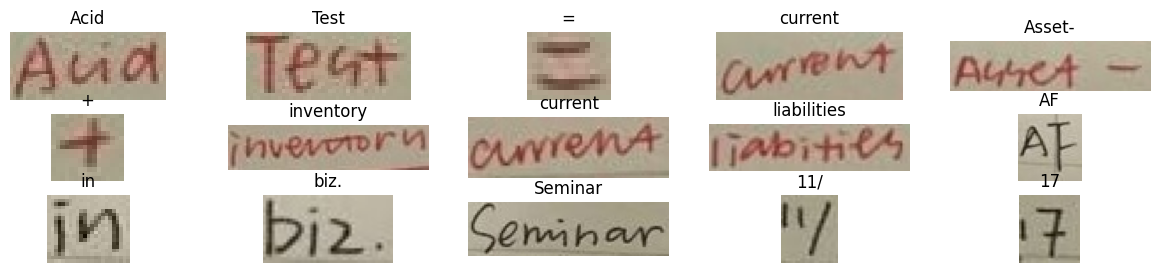

In [31]:
visualize(DatasetConfig.DATA_ROOT, sample_df)

In [32]:
train_df = pd.read_csv(
    os.path.join(DatasetConfig.DATA_ROOT, 'train_processed.csv'),
    header=None,
    skiprows=1,
    names=['image_filename', 'text']
)

test_df = pd.read_csv(
    os.path.join(DatasetConfig.DATA_ROOT, 'test_processed.csv'),
    header=None,
    skiprows=1,
    names=['image_filename', 'text']
)

In [33]:
train_df.head()

,image_filename,text
0,eng_NA_134_0.jpg,CSM:
1,eng_NA_134_1.jpg,Now
2,eng_NA_134_2.jpg,SPECIAL_CHARACTER
3,eng_NA_134_3.jpg,Me-
4,eng_NA_134_4.jpg,SPECIAL_CHARACTER


In [34]:
test_df.head()

,image_filename,text
0,eng_NA_013_0.jpg,Acid
1,eng_NA_013_1.jpg,Test
2,eng_NA_013_2.jpg,=
3,eng_NA_013_3.jpg,current
4,eng_NA_013_4.jpg,Asset-


In [35]:
# Augmentations.
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
])

In [36]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

        self.df['text'] = self.df['text'].fillna('')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['image_filename'][idx]
        # The text (label).
        text = self.df['text'][idx]

        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [37]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'train_processed/images/'),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'test_processed/images/'),
    df=test_df,
    processor=processor
)

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [38]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 32495
Number of validation examples: 10066


In [39]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


(-0.5, 282.5, 133.5, -0.5)

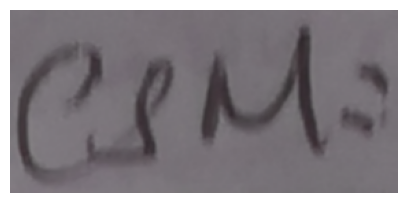

In [40]:
image = Image.open(train_dataset.root_dir + train_df['image_filename'][0]).convert("RGB")
image = train_transforms(image)
plt.figure(figsize=(5, 3))
plt.imshow(image)
plt.axis('off')

In [41]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

CSM:


In [42]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: [

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [43]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id

model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [44]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

In [45]:
cer_metric = evaluate.load('cer')

In [46]:
def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [47]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='trocr_handwritten/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS,
    dataloader_num_workers=8
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [48]:
# Initialize trainer.
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

/opt/conda/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [49]:
res = trainer.train('/kaggle/input/smallocr/checkpoint-6770')

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/transformers/trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Epoch,Training Loss,Validation Loss,Cer
6,0.097800,0.596781,0.254810
7,0.074900,0.581397,0.240935
8,0.051400,0.583838,0.236729
9,0.031400,0.582199,0.228759
10,0.018700,0.580712,0.227756


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1338: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation par

In [53]:
trainer.save_model("/kaggle/working/mymodel")

In [54]:
!zip -r archive.zip /kaggle/working/trocr_handwritten/checkpoint-13540

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/trocr_handwritten/checkpoint-13540/ (stored 0%)
  adding: kaggle/working/trocr_handwritten/checkpoint-13540/model.safetensors (deflated 15%)
  adding: kaggle/working/trocr_handwritten/checkpoint-13540/scheduler.pt (deflated 55%)
  adding: kaggle/working/trocr_handwritten/checkpoint-13540/training_args.bin (deflated 52%)
  adding: kaggle/working/trocr_handwritten/checkpoint-13540/preprocessor_config.json (deflated 52%)
  adding: kaggle/working/trocr_handwritten/checkpoint-13540/generation_config.json (deflated 40%)
  adding: kaggle/working/trocr_handwritten/checkpoint-13540/trainer_state.json (deflated 78%)
  adding: kaggle/working/trocr_handwritten/checkpoint-13540/rng_state.pth (deflated 25%)
  adding: kaggle/working/trocr_handwritten/checkpoint-13540/optimizer.pt (deflated 29%)
  adding: kaggle/working/trocr_handwritten/checkpoint-13540/config.json (deflated 77%)


In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [56]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model = VisionEncoderDecoderModel.from_pretrained('trocr_handwritten/checkpoint-'+str(res.global_step)).to(device)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [57]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.

    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [ ]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.


    Returns:
        generated_text: the OCR'd text string.
    """
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = trained_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [65]:
def eval_new_data(
    data_path=None,
    num_samples=100,
    df=None
):
    all_images = df.image_filename
    all_labels = df.text

    plt.figure(figsize=(100, 10))
    for i in range(num_samples):
        plt.subplot(10, 10, i+1)
        image = read_and_show(os.path.join(data_path, all_images[i]))
        text = ocr(image, processor, trained_model)
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
    plt.show()

KeyError: 50

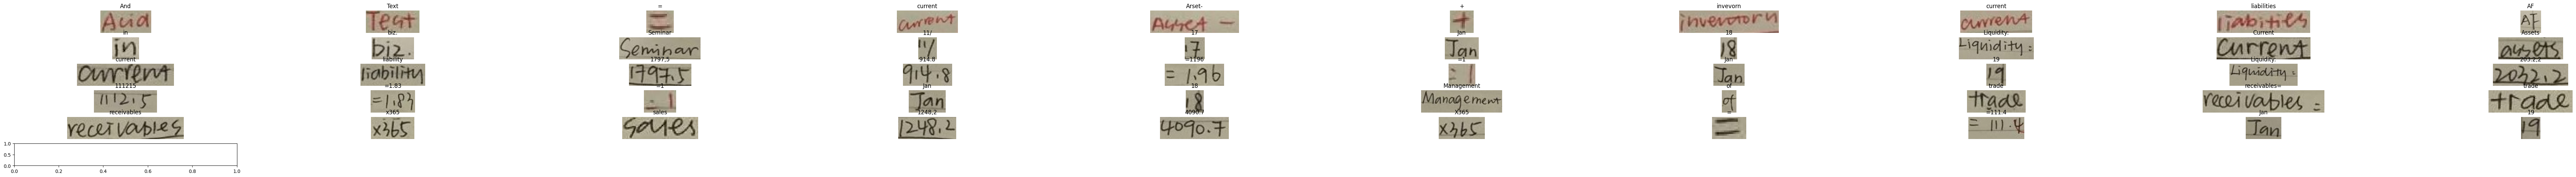

In [66]:
eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'test_processed/images'),
    num_samples=100,
    df=sample_df
)